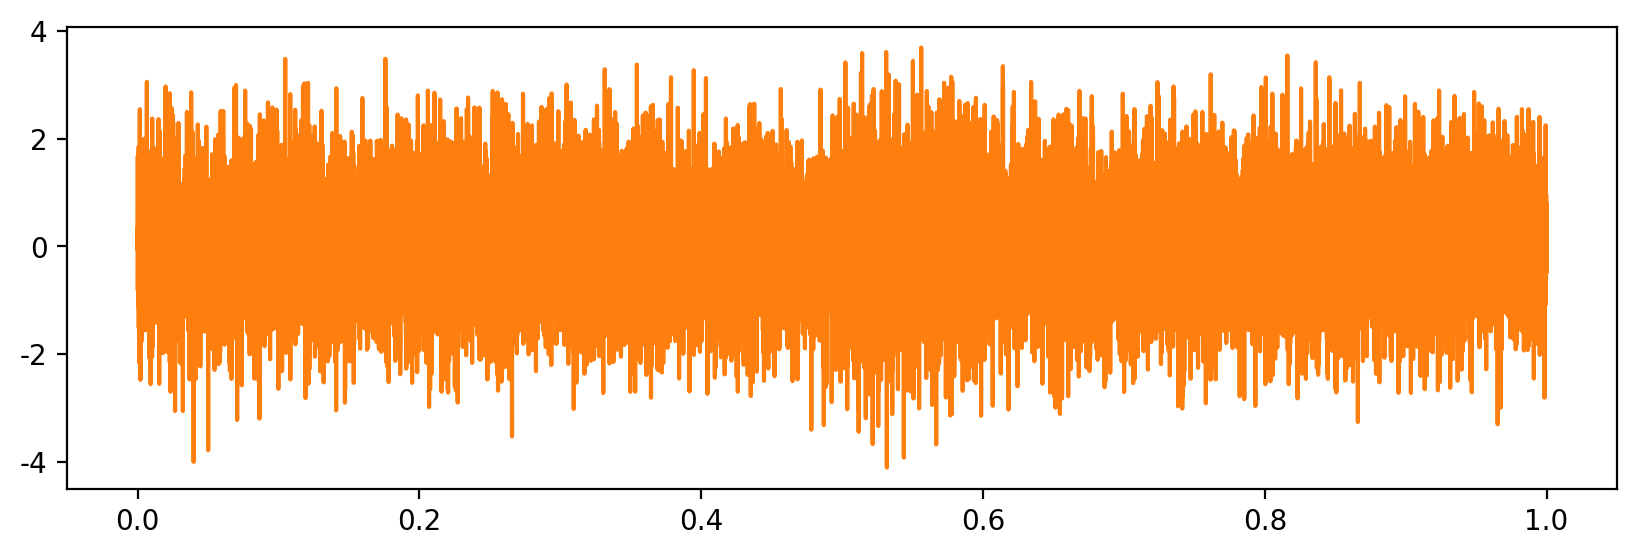

In [6]:
from pylab import *
import sounddevice as sd
rcParams['font.family'] = 'DejaVu Sans'
rcParams['figure.dpi'] = 200
rcParams['figure.figsize'] = 10,3


fs = 16000  # 采样率
f = 1000  # 频率（赫兹）
duration = 1  # 持续时间（秒）
t = np.linspace(0, duration, fs)  # 时间向量
x = np.sin(2 * np.pi * f * t)  # 生成正弦波
h = [0] * (fs * duration // 2) + [1] * (fs * duration // 10) + [0] * (fs * duration // 2 - fs * duration // 10)
x = x*h
plot(t, x)
noise = np.random.normal(0, 1, fs * duration)  # 生成高斯白噪声
# plot(noise)
# sd.play(noise, fs)
sd.play(x+noise/5, fs)
sd.wait()  # Wait until the sound has finished playing
plot(t,x+noise)

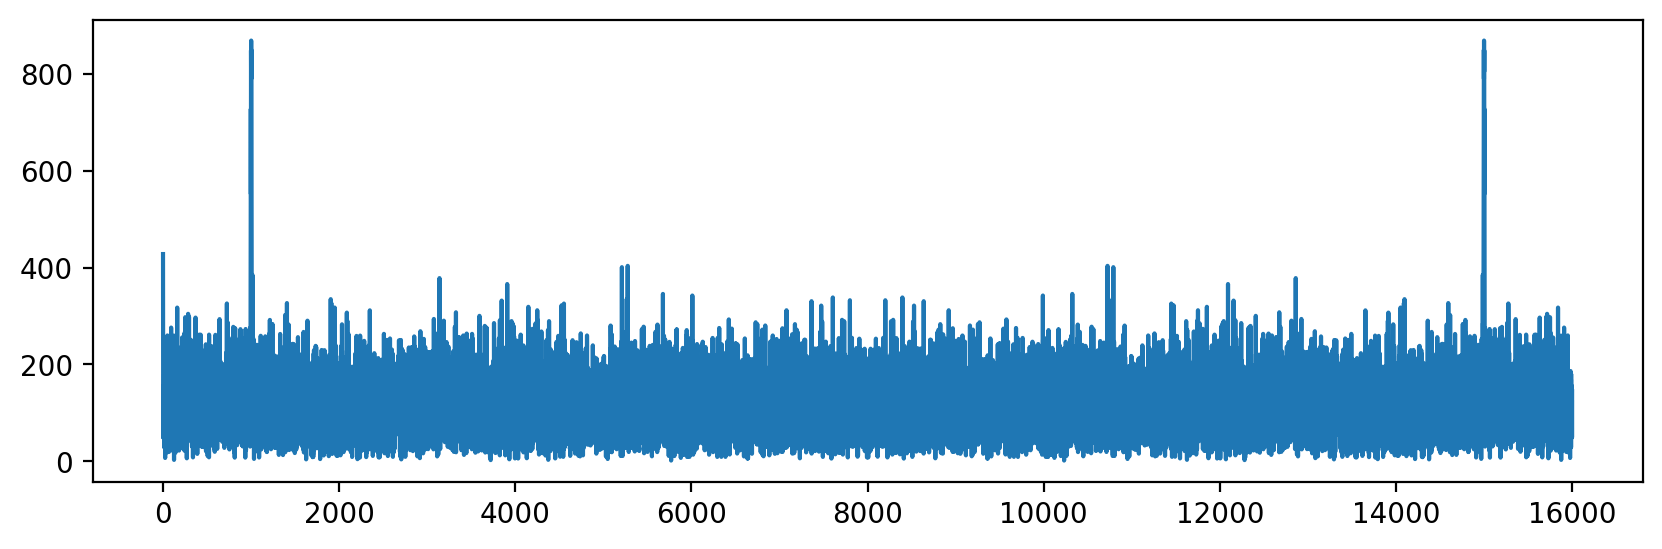

In [7]:
y = np.fft.fft(x+noise)
f0 = 1/duration
fx = np.linspace(0, fs, fs * duration,endpoint=False)
plot(fx, abs(y))

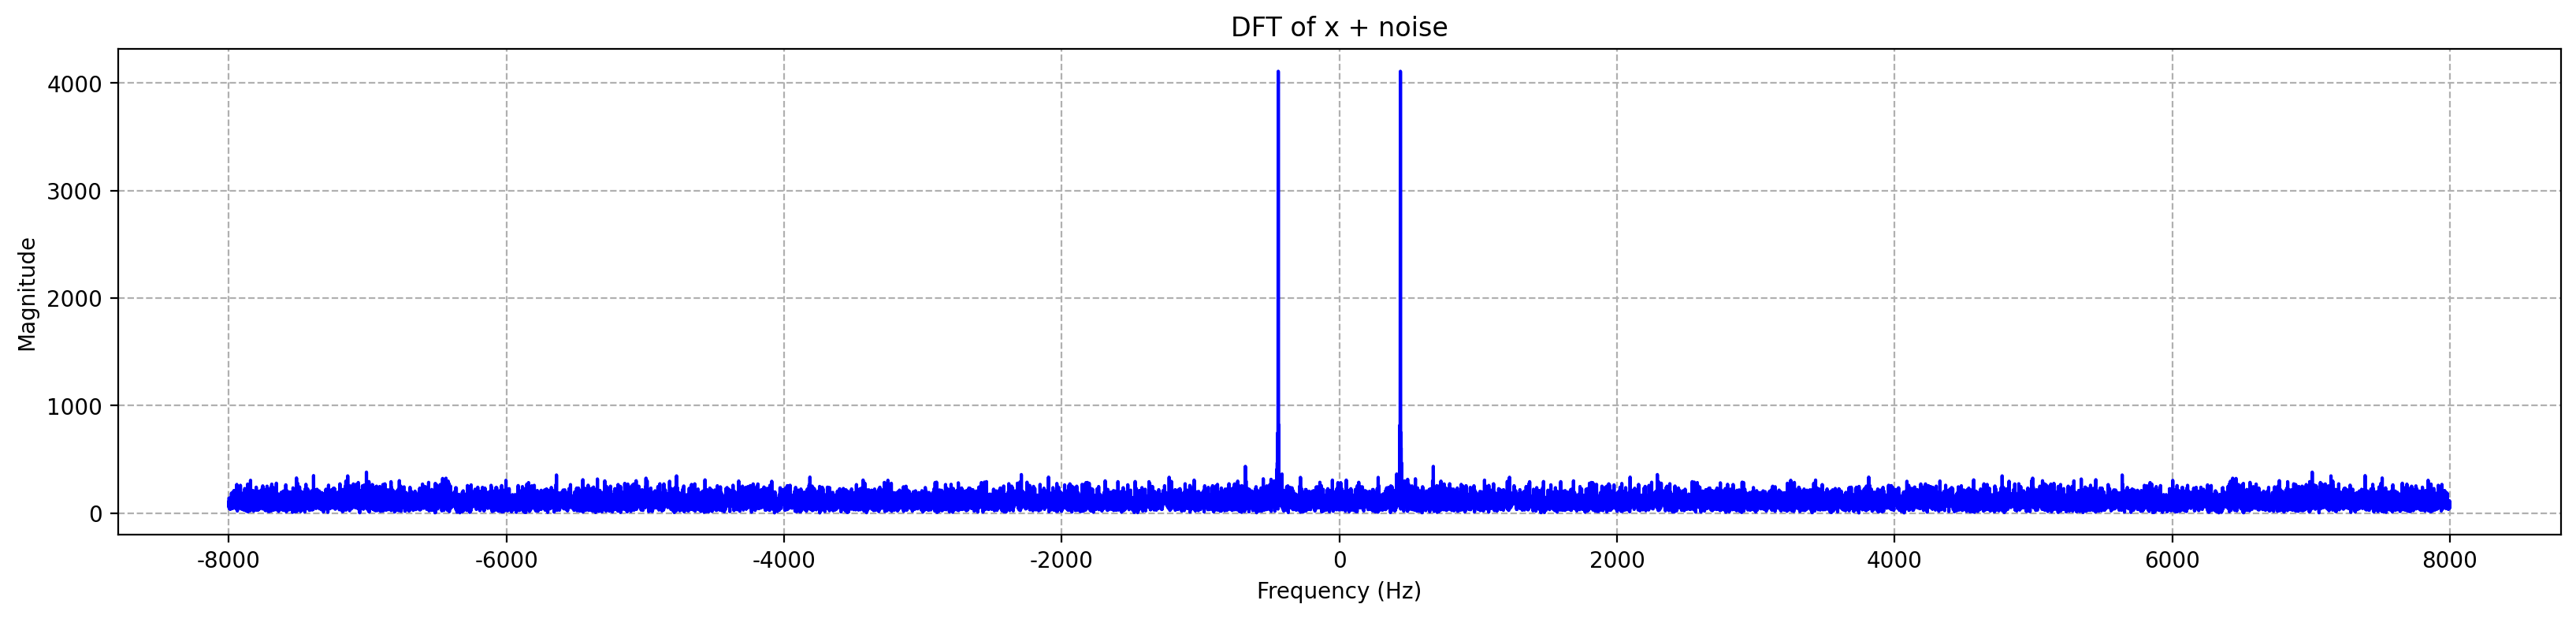

In [ ]:
# 计算DFT
x_plus_noise = x + noise

N = len(x_plus_noise)
X = np.fft.fft(x_plus_noise)
magnitude = np.abs(X)

# 创建频率轴（单边频谱）
freq = np.fft.fftfreq(N, d=1/fs)


# 绘制DFT
figure()
plot(freq, magnitude, 'b')  # 使用对数幅度更清晰
xlabel('Frequency (Hz)')
ylabel('Magnitude')
title('DFT of x + noise')
grid(True, which="both", linestyle='--')  # 添加网格线

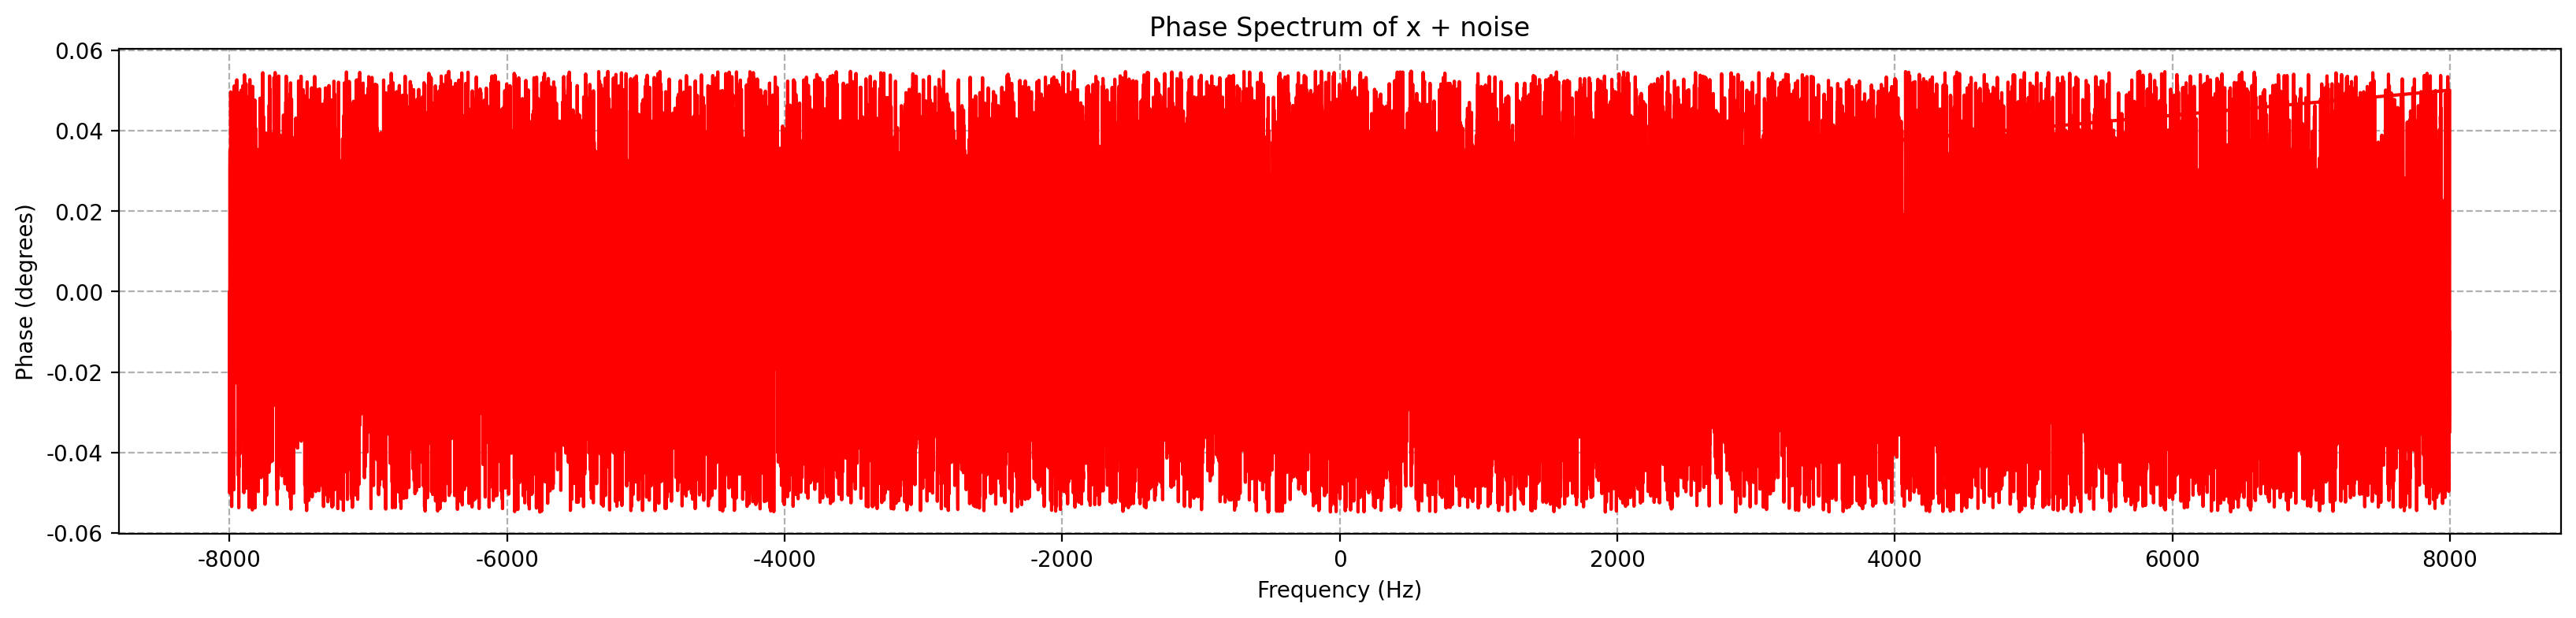

In [ ]:
# 计算相位谱
phase = np.angle(X)  # 获取相位（弧度）
phase_single = phase[:N//2]  # 取单边相位

# 相位解缠处理（消除-π到π的跳跃）
phase_unwrapped = np.mod(np.unwrap(phase_single),360)
freq = np.fft.fftfreq(N, d=1/fs)
# 绘制相位谱
figure()
plot(freq, np.deg2rad(phase), 'r')  # 转换为角度显示
xlabel('Frequency (Hz)')
ylabel('Phase (degrees)')
title('Phase Spectrum of x + noise')
grid(True, linestyle='--')

# 可选：同时显示幅度和相位的子图
# figure()
# subplot(2,1,1)
# semilogy(freq_single, magnitude_single, 'b')
# subplot(2,1,2)
# plot(freq_single, phase_unwrapped, 'r')
# show()

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


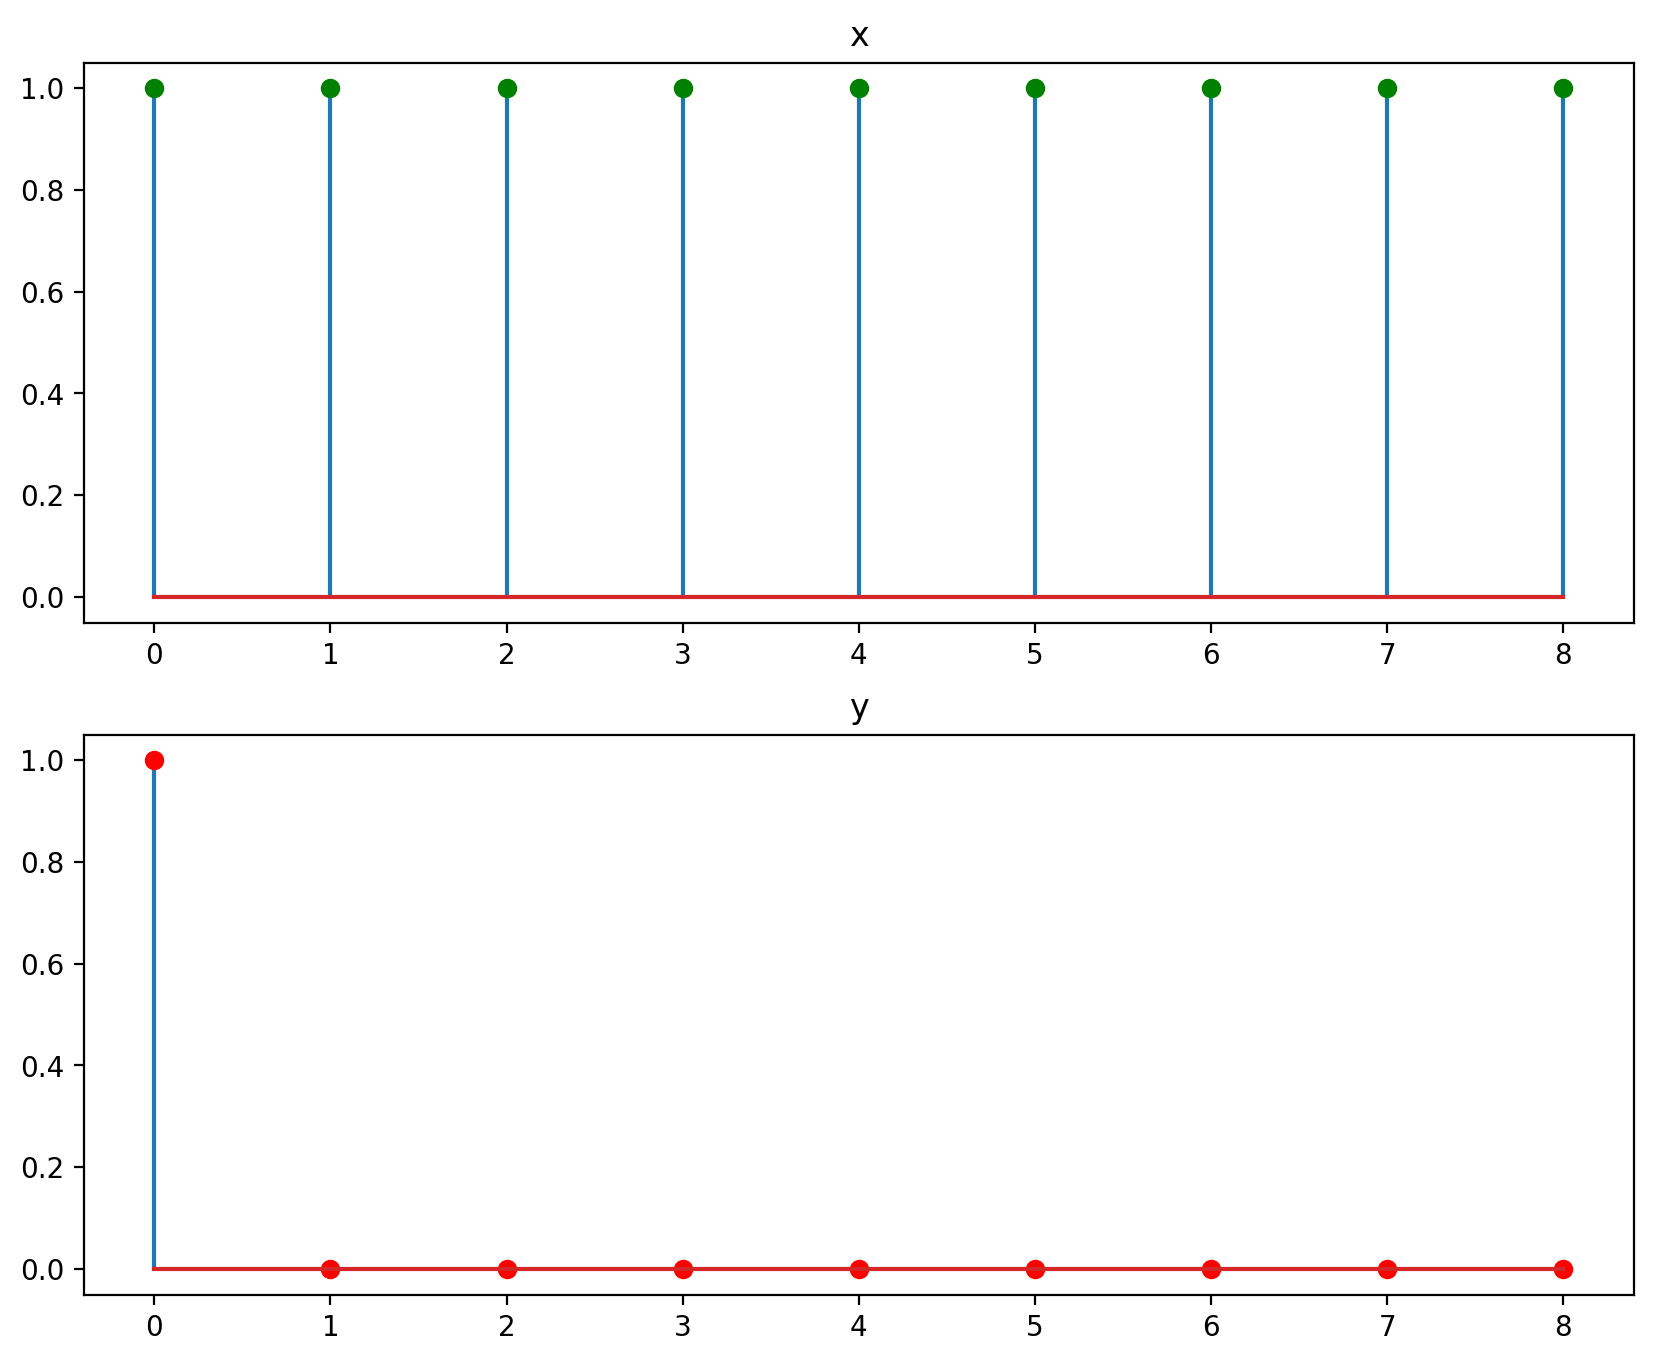

In [ ]:
# x = np.array([0,0,0,0,1,0,0,0,0])
x = np.ones(9)
y = np.fft.fft(x)/len(x)
fig = figure(figsize=(10,8))
ax = fig.add_subplot(211)
ax.stem(x,markerfmt='g')
ax.set_title('x')
ax = fig.add_subplot(212)
ax.set_title('y')
ax.stem(abs(y),markerfmt='r')
print(y)

In [2]:
from pylab import *
import sounddevice as sd

duration = 1
fs = 16e3  # 采样率
n_samples_noise = int(fs * duration)  # 噪声样本数
noise_power = 1.44  # 噪声功率
pn_ratio = 0.3
pure_power = pn_ratio * noise_power  # 信号功率
amplitude_pure = np.sqrt(2 * pure_power)
noise1 = np.sqrt(noise_power) * np.random.randn(n_samples_noise)
pure_tone = amplitude_pure * np.sin(2 * np.pi * 1000 * np.arange(n_samples_noise)/fs)
# plot(pure_tone)
rms_noise1 = np.sqrt(np.mean(noise1**2))
rms_pure_tone = np.sqrt(np.mean(pure_tone**2))

noise2 = np.sqrt(noise_power) * np.random.randn(n_samples_noise)
blank = np.zeros(int(n_samples_noise/2))

pure_tone[0:int(0.5*n_samples_noise)] = 0
pure_tone[int(0.6*n_samples_noise):] = 0

i = np.random.randint(0,2)
if i == 0:
    noise1 = noise1 + pure_tone
else:
    noise2 = pure_tone + noise2

signal = np.hstack([noise1, blank, noise2])  # Now all arrays have the same size along the concatenation axis
sd.play(signal, fs)

In [43]:
import numpy as np
from scipy.signal import firwin, lfilter, freqz, spectrogram
import matplotlib.pyplot as plt

def apply_cosine_ramp(audio, sample_rate, fade_time=0.02):
    """
    应用余弦曲线淡入淡出(最平滑的过渡)
    """
    fade_length = int(fade_time * sample_rate)
    
    # 余弦淡入
    fade_in = (1 - np.cos(np.linspace(0, np.pi, fade_length))) / 2
    
    # 余弦淡出
    fade_out = (1 + np.cos(np.linspace(0, np.pi, fade_length))) / 2
    
    audio[:fade_length] *= fade_in
    audio[-fade_length:] *= fade_out
    
    return audio

# 参数设置
fs = 16000  # 采样频率，单位为 Hz
A = 0.2  # 示例值，根据实际需求调整
f1 = (1 - A) * 1000  # 带通滤波器下限频率
f2 = (1 + A) * 1000  # 带通滤波器上限频率
n = 64  # 滤波器阶数，可根据需求调整



# 归一化频率
f1 = f1 / (fs / 2)  # 将频率归一化到 Nyquist 频率
f2 = f2 / (fs / 2)  # 将频率归一化到 Nyquist 频率
Wn = [f1, f2] 

# 设计 FIR 带通滤波器
b = firwin(n + 1, Wn, pass_zero='bandpass', window='hamming')

# 生成白噪声
t = np.arange(0, 1, 1/fs)  # 时间序列
noise = np.random.randn(len(t))  # 生成白噪声



# 应用滤波器
filtered_noise = lfilter(b, 1, noise)

# 计算滤波后信号的 RMS 值
rms_filtered_noise = np.sqrt(np.mean(filtered_noise**2))

# 归一化滤波后的信号
normalized_filtered_noise = filtered_noise / rms_filtered_noise

# 验证归一化后的信号功率
rms_normalized_filtered_noise = np.sqrt(np.mean(normalized_filtered_noise**2))
print(f"归一化后的信号 RMS 值: {rms_normalized_filtered_noise:.6f}")

# FFT 参数
N = len(t)  # FFT 点数
f = np.linspace(0, fs, N)  # 频率轴

# 计算 FFT
fft_noise = np.fft.fft(noise)
fft_filtered_noise = np.fft.fft(filtered_noise)
fft_normalized_filtered_noise = np.fft.fft(normalized_filtered_noise)

# 计算幅度谱（取模并归一化）
fft_noise_mag = np.abs(fft_noise) / N
fft_filtered_noise_mag = np.abs(fft_filtered_noise) / N
fft_normalized_filtered_noise_mag = np.abs(fft_normalized_filtered_noise) / N


pn_ratio = 1.2
noise_power =np.sqrt(np.mean(normalized_filtered_noise**2))
t2 = np.arange(0,0.1,1/fs)  # 时间序列
n_samples_noise = len(t2)
pure_power = pn_ratio * np.sqrt(np.mean(normalized_filtered_noise**2))  # 信号功率
amplitude_pure = np.sqrt(2 * pure_power)
noise1 = normalized_filtered_noise
pure_tone = amplitude_pure * np.sin(2 * np.pi * 1000 * np.arange(n_samples_noise)/fs)
pure_tone= apply_cosine_ramp(pure_tone, fs, fade_time=0.02)
rms_noise1 = np.sqrt(np.mean(noise1**2))
rms_pure_tone = np.sqrt(np.mean(pure_tone**2))

noise2 = noise1
blank = np.zeros(int(len(t)/2))

pure_tone = np.hstack([np.zeros(int(0.5*len(t))),pure_tone,np.zeros(int(0.4*len(t)))])

i = np.random.randint(0,2)
if i == 0:
    noise1 = noise1 + pure_tone
else:
    noise2 = pure_tone + noise2

signal = np.hstack([noise1, blank, noise2])  # Now all arrays have the same size along the concatenation axis
sd.play(signal, fs)
# # 绘制频谱图
# plt.figure(figsize=(12, 12))
# plt.subplot(3, 1, 1)
# plt.plot(f[:N//2], fft_noise_mag[:N//2])
# plt.title('原始白噪声的频谱')
# plt.xlabel('频率 (Hz)')
# plt.ylabel('幅度')
# plt.xlim([0, fs/2])  # 只显示正频率部分

# plt.subplot(3, 1, 2)
# plt.plot(f[:N//2], fft_filtered_noise_mag[:N//2])
# plt.title('滤波后信号的频谱')
# plt.xlabel('频率 (Hz)')
# plt.ylabel('幅度')
# plt.xlim([0, fs/2])  # 只显示正频率部分

# plt.subplot(3, 1, 3)
# plt.plot(f[:N//2], fft_normalized_filtered_noise_mag[:N//2])
# plt.title('归一化后的滤波信号的频谱')
# plt.xlabel('频率 (Hz)')
# plt.ylabel('幅度')
# plt.xlim([0, fs/2])  # 只显示正频率部分
# plt.tight_layout()
# plt.show()

归一化后的信号 RMS 值: 1.000000


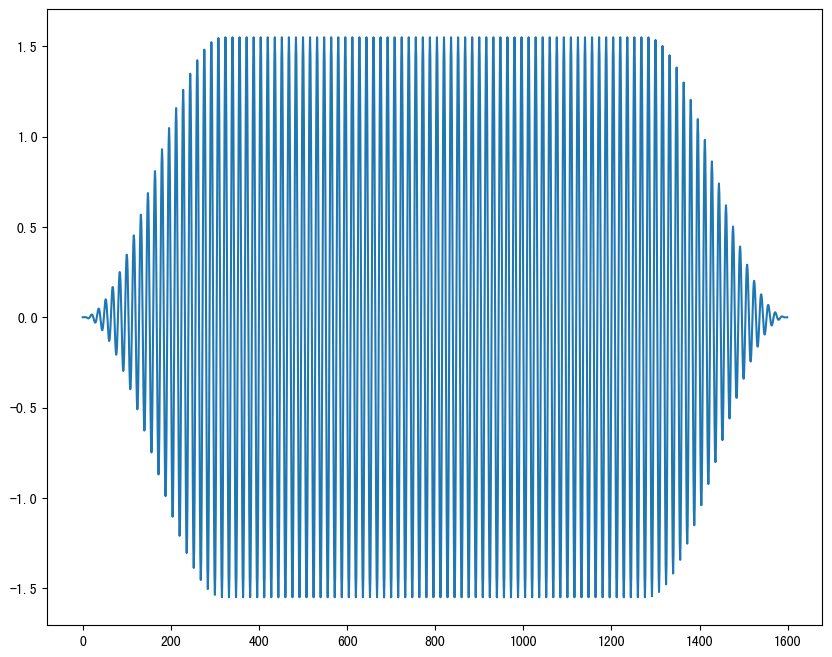

In [ ]:
from pylab import *
fig = figure(figsize=(10,8))
ax = fig.add_subplot(111)

ax.plot(pure_tone)
# ax.set_xlim([7990,8210])


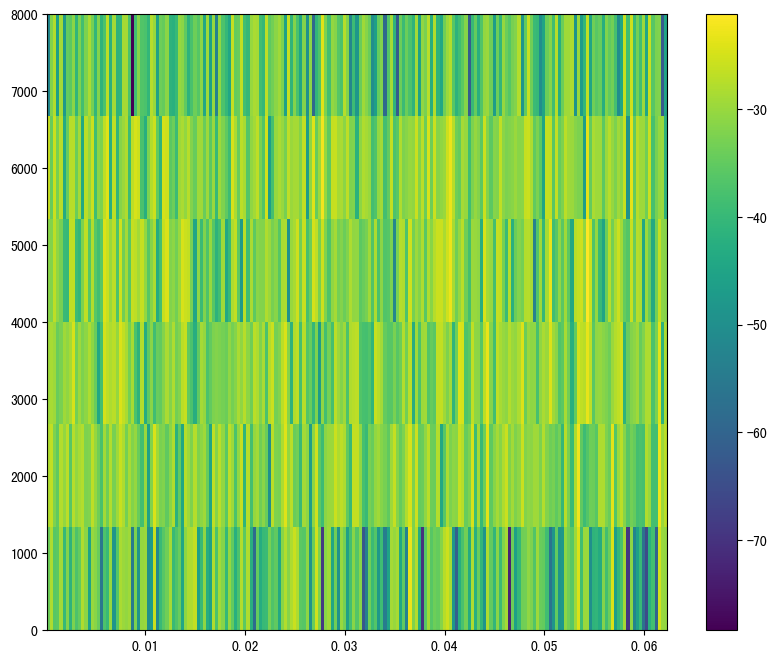

In [56]:
fs = 16000
x = 3*np.random.randn(1000)
win = 10
fig = figure(figsize=(10,8))
ax = fig.add_subplot(111)
spec, freqs, bins, im = ax.specgram(x, Fs=fs, NFFT=win, noverlap=win//2)
fig.colorbar(im, ax=ax)
